In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets

In [2]:
subfolders = sorted([ dir for dir in os.listdir('.') if os.path.isdir(dir) and dir != '.ipynb_checkpoints'])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> input_FinerGrid_0013



In [3]:
a = subfolders[-1]
#a = subfolders[1]

In [4]:
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
gams,thes = dictio['gams'],dictio['thes']
lastV = len(filesList)-1

# 1d slices

In [5]:
gamL = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape

In [6]:
def sliceGammas(h5File):
    wf  = qp.retrieve_hdf5_data(h5File,'WF')
    fig = plt.figure(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
    ys = wf
    time = qp.retrieve_hdf5_data(h5File,'Time')[0]
    plt.title('Time = {:10.5f} fs'.format(time))
    plt.ylim(-0.7,0.7)
    plt.plot(gams, np.real(ys), linewidth=1,ls='--')
    plt.plot(gams, np.imag(ys), linewidth=1,ls='--')
    plt.plot(gams, abs2(ys), linewidth=3,ls='-')

def fgam(file_number):
    return sliceGammas(os.path.join(a, filesList[file_number]))


In [7]:
interact(fgam, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));

interactive(children=(IntSlider(value=709, description='file_number', max=709), Output()), _dom_classes=('widg…

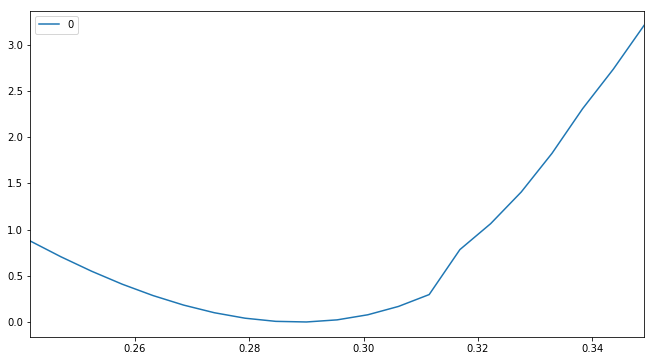

In [8]:
pd.DataFrame(qp.fromHartoEv(dictio['potCube'])).plot(x=gams,figsize=(11, 6));

In [9]:
def kinGam(xder):
    pd.DataFrame(dictio['kinCube'][:,4,xder]).plot(x=gams,figsize=(11, 6))
    
interact(kinGam, xder = widgets.IntSlider(min=0,max=2,step=1,value=0));

interactive(children=(IntSlider(value=0, description='xder', max=2), Output()), _dom_classes=('widget-interact…

In [10]:
outfn = os.path.join(a,'output')

In [11]:
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
data.columns = ['steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation']
data

,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation
0,0,0.000000,0.824346,0.000055,0.000176,0.000231,0.000000e+00
1,50,0.500496,0.824346,0.000063,0.000168,0.000231,2.230196e-09
2,100,1.000993,0.824347,0.000082,0.000149,0.000231,8.546308e-09
3,150,1.501489,0.824349,0.000106,0.000125,0.000231,1.822651e-08
4,200,2.001985,0.824351,0.000130,0.000101,0.000231,3.036227e-08
5,250,2.502482,0.824354,0.000151,0.000080,0.000231,4.397541e-08
6,300,3.002978,0.824357,0.000167,0.000064,0.000231,5.837770e-08
7,350,3.503475,0.824360,0.000178,0.000052,0.000231,7.314531e-08
8,400,4.003971,0.824364,0.000185,0.000045,0.000231,8.802640e-08
9,450,4.504467,0.824367,0.000188,0.000042,0.000231,1.028035e-07


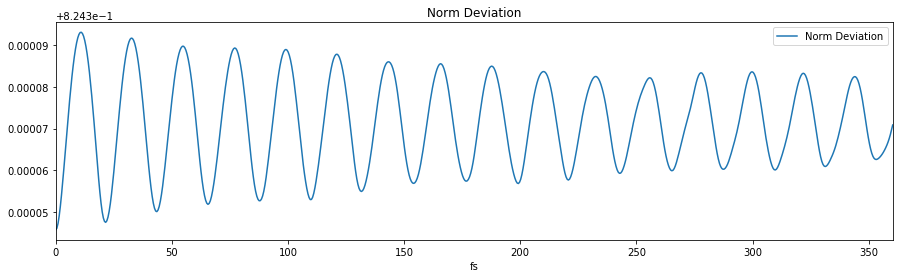

In [12]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4));

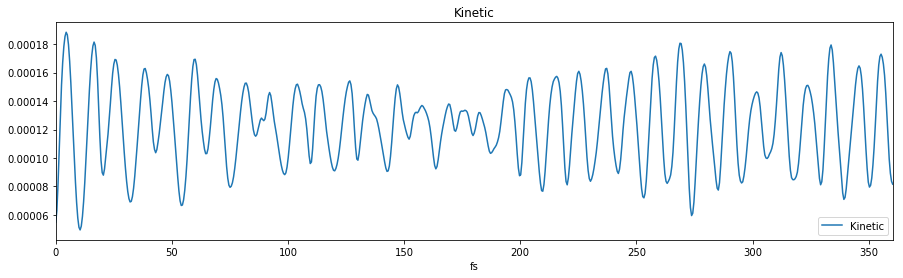

In [13]:
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));

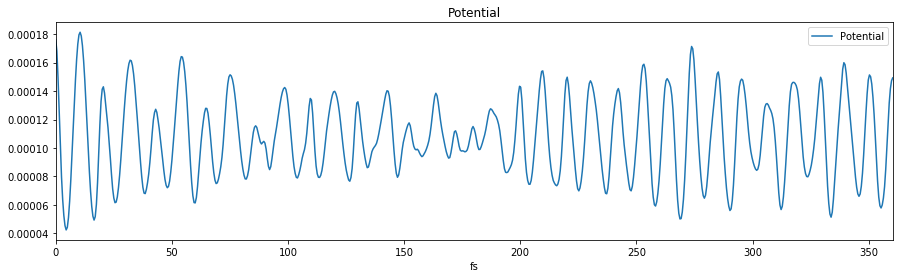

In [14]:
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));

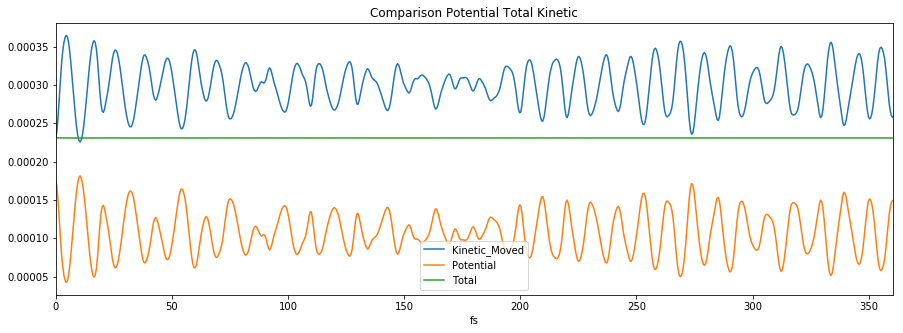

In [15]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

### Expected values

In [21]:
def expected(h5file):
    wfa  = qp.retrieve_hdf5_data(h5file,'WF')
    norm = np.linalg.norm(wfa)
    wf = wfa / norm
    gamAvg = np.vdot(abs2(wf),gams)
    print('Norm: {}\n\nExpected Values:\nGamma: {:10.5f}'.format(norm,np.rad2deg(gamAvg)))

def fexp(x):
    return expected(os.path.join(a,filesList[x]))

In [22]:
interact(fexp, x = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));

interactive(children=(IntSlider(value=709, description='x', max=709), Output()), _dom_classes=('widget-interac…